# Plant Lithology 2021  Competition

In [95]:
import os
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt 
import PIL
from PIL import Image
from skimage import io
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms,utils

### Data Paths

In [94]:
train_images_path = '/train_images'
#test_image_path = '/test_images'
train_df_path = 'train.csv'
test_df_path = 'sample_submission.csv'

### Getting the frequencies of each different class

### Loading training data

In [3]:
train_df = pd.read_csv(train_df_path)
train_df

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex
...,...,...
18627,fffb900a92289a33.jpg,healthy
18628,fffc488fa4c0e80c.jpg,scab
18629,fffc94e092a59086.jpg,rust
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot


In [4]:
class_freq = train_df['labels'].value_counts()
class_freq

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

In [5]:
labels = class_freq.index.to_list()
freqs = class_freq.values

label_df = pd.DataFrame(data = {'labels': labels, 'frequencies': freqs} )

label_df['labels']= (label_df['labels'].str.replace('_'," ")).str.title()
label_df

,labels,frequencies
0,Scab,4826
1,Healthy,4624
2,Frog Eye Leaf Spot,3181
3,Rust,1860
4,Complex,1602
5,Powdery Mildew,1184
6,Scab Frog Eye Leaf Spot,686
7,Scab Frog Eye Leaf Spot Complex,200
8,Frog Eye Leaf Spot Complex,165
9,Rust Frog Eye Leaf Spot,120


### Plotting frequency of labels

In [6]:
fig = px.bar(label_df, x='labels', y='frequencies')
fig.show()

### Make a plot to see the different types of classes

In [7]:
label_df = train_df.groupby('labels').first().reset_index()
label_df

,labels,image
0,complex,800cbf0ff87721f8.jpg
1,frog_eye_leaf_spot,80273091d9e9bddb.jpg
2,frog_eye_leaf_spot complex,808734da3f595b59.jpg
3,healthy,800113bb65efe69e.jpg
4,powdery_mildew,802f7439ec1ef0cd.jpg
5,powdery_mildew complex,809495769b64f3b5.jpg
6,rust,800f85dc5f407aef.jpg
7,rust complex,81ee9fb0217b14d3.jpg
8,rust frog_eye_leaf_spot,80933fcc6a673636.jpg
9,scab,80070f7fb5e2ccaa.jpg


In [8]:
labels,images = label_df['labels'],label_df['image']

labels,images

(0                             complex
 1                  frog_eye_leaf_spot
 2          frog_eye_leaf_spot complex
 3                             healthy
 4                      powdery_mildew
 5              powdery_mildew complex
 6                                rust
 7                        rust complex
 8             rust frog_eye_leaf_spot
 9                                scab
 10            scab frog_eye_leaf_spot
 11    scab frog_eye_leaf_spot complex
 Name: labels, dtype: object,
 0     800cbf0ff87721f8.jpg
 1     80273091d9e9bddb.jpg
 2     808734da3f595b59.jpg
 3     800113bb65efe69e.jpg
 4     802f7439ec1ef0cd.jpg
 5     809495769b64f3b5.jpg
 6     800f85dc5f407aef.jpg
 7     81ee9fb0217b14d3.jpg
 8     80933fcc6a673636.jpg
 9     80070f7fb5e2ccaa.jpg
 10    80769797ce42f658.jpg
 11    8002cb321f8bfcdf.jpg
 Name: image, dtype: object)

In [9]:
def display_grid(xs, titles, rows, cols,figsize=(12, 6)):
    """Displays examples in a grid."""
    
    #Aqui en lugar de un array con los arrays de imagenes se pasan las rutas de las imagenes
    assert len(xs.index)==(rows*cols), 'Mismatch between df length and input sizes'
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            print(xs[i])
            ax[r, c].imshow(plt.imread(f"train_images/{xs[i]}"), cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()

800cbf0ff87721f8.jpg
80273091d9e9bddb.jpg
808734da3f595b59.jpg
800113bb65efe69e.jpg
802f7439ec1ef0cd.jpg
809495769b64f3b5.jpg
800f85dc5f407aef.jpg
81ee9fb0217b14d3.jpg
80933fcc6a673636.jpg
80070f7fb5e2ccaa.jpg
80769797ce42f658.jpg
8002cb321f8bfcdf.jpg


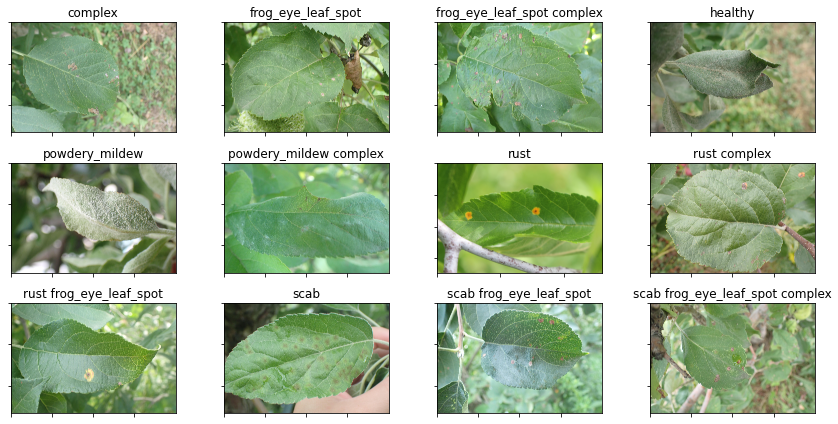

In [10]:
display_grid(images,labels,3,4)

## Creating a Dataset Class

Start to create a simple function to display a sample

In [12]:
def show_image(image_path, image_name):
    '''
    Show an image sample from a dataset
    '''
    print(f'Image name: {image_name}')
    plt.imshow(io.imread(image_path))
    

Image name: 800113bb65efe69e.jpg


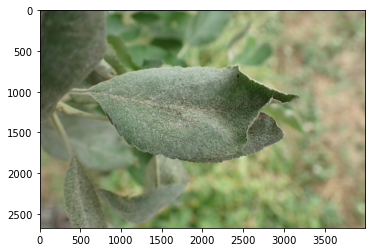

In [13]:
#Example using show_image function 
image_name = train_df['image'].iloc[0]
show_image(os.path.join('train_images/',image_name),image_name)

Now we can create our dataset class

In [96]:
class PlantPathologyDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform = None):
        
        self.plant_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.image_names = self.plant_df.iloc[:,0]
        self.labels = self.plant_df.iloc[:,1]
        self.transform = transform

    def __len__(self):
        return len(self.plant_df)

    def __getitem__(self,idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image = Image.open(os.path.join(self.root_dir, self.image_names[idx]))
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)

        return image,label 




In [97]:
plant_dataset = PlantPathologyDataset('train.csv','train_images/')

In [98]:
len(plant_dataset)

18632

In [99]:
plant_dataset[1]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4000x2672 at 0x7F9D9959C7C0>,
 'scab frog_eye_leaf_spot complex')

0 (4000, 2672)
1 (4000, 2672)
2 (4000, 2672)
3 (4000, 2672)


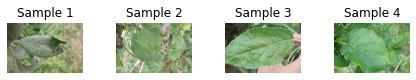

In [102]:
for i in range(len(plant_dataset)):
    if i > 3:
        break
    sample = plant_dataset[i]
    print(i, sample[0].size)
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(f'Sample {i+1}')
    ax.axis('off')
    plt.imshow(sample[0])


    
    

## Transforms

As you have seen in the example above, at least one of the images have a different shape from the rest, so we have to ensure that our future tensors have the same shape. Despite we have proved the existence of different image shapes with the previous example, we must apply a transform to ensure all inputs have the same shape, whether we are sure or not that all of them are the same shape

We can use the Torchvision module and its transforms or we can implement our own

In [92]:
dir(transforms)

['CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandomAffine',
 'RandomApply',
 'RandomChoice',
 'RandomCrop',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomOrder',
 'RandomPerspective',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

In [109]:
#Creating instances of the transform classes
to_tensor = transforms.ToTensor()
resize = transforms.Resize(256)
crop = transforms.RandomCrop(128)

Let´s apply these transforms to a sample

In [112]:
samp_1 = plant_dataset[0]
samp_2 = plant_dataset[0]

tsfm_1 = resize(samp_1[0])

resize = transforms.Resize(128)
tsfm_2 = resize(samp_2[0])

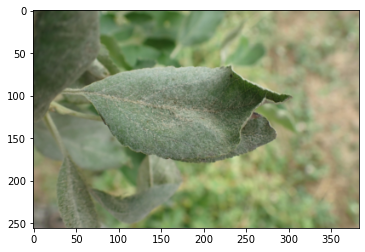

In [113]:
plt.imshow(tsfm_1)

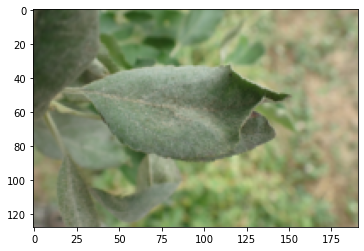

In [114]:
plt.imshow(tsfm_2)

Another transform we have to apply is Normalizing the images. Since we are working with PIL images we must transform the dataset images to tensors first:

In [140]:
tensor_plants = PlantPathologyDataset('train.csv','train_images/', transform = transforms.Compose([
                                                                                        transforms.ToTensor(),
                                                                                        transforms.Resize((128,128))]))

We dont have sufficient RAM to store the whole dataset and get the mean and standard deviation of the 3 channels in all images, this is why whe need a data loader to load the data in batches.

In [141]:
train_loader = DataLoader(tensor_plants, batch_size = 64, shuffle = True)

In [142]:
train_loader

In [143]:
def get_mean_std(loader):

    channels_sum, channels_squared_sum, num_batches = 0,0,0

    for data, _ in loader:
        channels_sum += torch.mean(data, dim = [0,2,3])
        print(channels_sum) 

In [144]:
get_mean_std(train_loader)

tensor([0.4901, 0.6243, 0.4066])
tensor([0.9745, 1.2518, 0.8209])


KeyboardInterrupt: 